# Blackjack Card Counter Classification Model
- This notebook presents a step-by-step analysis to predict whether a player is using card counting strategies in blackjack.  
- We explore and preprocess the data, train multiple classification models (Logistic Regression, SVM, Random Forest), tune hyperparameters, evaluate performance, and visualize feature importance.  
- The goal is to understand which factors most influence card counting detection and to identify the most effective model for this task.

## 1. Notebook Setup & Data Loading
### 1.1 Setup and Loading Data
- We scan the data folder, finds all Excel files, and list them.
- It ensures we don’t proceed if the folder is empty or incorrectly set.

In [1]:
# Core imports
import os
from pathlib import Path
import pandas as pd
import numpy as np

# Path to the folder where all Excel datasets are stored
# Example for Windows: r"C:\Users\you\projects\blackjack\data"
# Example for Mac/Linux: "/Users/you/projects/blackjack/data"
DATA_DIR = "./Datasets"  # change if your data is in a different location

# Columns we expect to see in every file
# Helps us catch typos or missing fields early
REQUIRED_COLS = {
    "Player_Value",
    "Dealer_UpCard",
    "Soft",
    "Pair",
    "Bet Size",
    "Action",
    "True_Count",
    "Card_Counter",
}

In [2]:
# Converting the folder path to a Path object for easier file handling
data_dir = Path(DATA_DIR)

# Getting a sorted list of all Excel files in the folder
xlsx_files = sorted(data_dir.glob("*.xlsx"))

# Stopping the script early if no Excel files are found
if not xlsx_files:
    raise FileNotFoundError(
        f"No .xlsx files found in {data_dir.resolve()}. "
        "Update DATA_DIR to the correct folder."
    )

# Showing the number of files found and list their names
print(f"Found {len(xlsx_files)} Excel file(s):")
for fp in xlsx_files:
    print("-", fp.name)

Found 10 Excel file(s):
- CardCountingData_BasicStrategy_Counter_AggressiveSpread.xlsx
- CardCountingData_BasicStrategy_Counter_FlatBet.xlsx
- CardCountingData_BasicStrategy_Counter_MidSpread.xlsx
- CardCountingData_BasicStrategy_Counter_PassiveSpread.xlsx
- CardCountingData_BasicStrategy_NotCounter_FlatBet.xlsx
- CardCountingData_BasicStrategy_NotCounter_RandomBet.xlsx
- CardCountingData_CasinoStrategy_NotCounter_FlatBet.xlsx
- CardCountingData_CasinoStrategy_NotCounter_RandomBet.xlsx
- CardCountingData_RandomStrategy_NotCounter_FlatBet.xlsx
- CardCountingData_RandomStrategy_NotCounter_RandomBet.xlsx


### 1.2 Loading the Excel Files
- Loading each Excel file, checking for missing columns, and keeping only valid datasets. Any files with problems are skipped, ensuring only usable data moves forward.

In [3]:
frames = []

# Looping through each Excel file and load it into a DataFrame
for fp in xlsx_files:
    try:
        df = pd.read_excel(fp, sheet_name=0)
        df.columns = [c.strip() for c in df.columns]  # remove extra spaces in column names

        # Check for any missing required columns
        missing = REQUIRED_COLS.difference(df.columns)
        if missing:
            print(f"Skipping '{fp.name}' — missing columns: {sorted(missing)}")
            continue

        # Store the DataFrame if it's valid
        frames.append(df)
        print(f"Loaded '{fp.name}' -> rows: {len(df)}")
    except Exception as e:
        print(f"Error reading '{fp.name}': {e}")

# Stopping if no valid datasets were loaded
if not frames:
    raise RuntimeError(
        "No valid datasets were loaded (all missing required columns or failed to read)."
    )

Loaded 'CardCountingData_BasicStrategy_Counter_AggressiveSpread.xlsx' -> rows: 4814
Loaded 'CardCountingData_BasicStrategy_Counter_FlatBet.xlsx' -> rows: 4814
Loaded 'CardCountingData_BasicStrategy_Counter_MidSpread.xlsx' -> rows: 4814
Loaded 'CardCountingData_BasicStrategy_Counter_PassiveSpread.xlsx' -> rows: 4814
Loaded 'CardCountingData_BasicStrategy_NotCounter_FlatBet.xlsx' -> rows: 4800
Loaded 'CardCountingData_BasicStrategy_NotCounter_RandomBet.xlsx' -> rows: 4800
Loaded 'CardCountingData_CasinoStrategy_NotCounter_FlatBet.xlsx' -> rows: 4800
Loaded 'CardCountingData_CasinoStrategy_NotCounter_RandomBet.xlsx' -> rows: 4800
Loaded 'CardCountingData_RandomStrategy_NotCounter_FlatBet.xlsx' -> rows: 4800
Loaded 'CardCountingData_RandomStrategy_NotCounter_RandomBet.xlsx' -> rows: 4800


### 1.3 Combining Excel Data in one Data Frame
- This combines all loaded files into a single dataset, printing an overview of its structure, showing class distribution for `Card_Counter`, and previewing the first few rows.

In [4]:
# Combining all valid DataFrames into one
data = pd.concat(frames, ignore_index=True)

# Basic summary of the combined dataset
print("\n--- Combined Dataset Summary ---")
print(f"Total rows: {len(data):,}")
print(f"Total columns: {len(data.columns)}")
print("Columns:", list(data.columns))

# Showing how many card counters vs non-counters we have
print("\nClass balance for 'Card_Counter':")
print(data["Card_Counter"].value_counts(dropna=False))

# Previewing the first few rows
print("\nPreview of dataset:")
display(data.head(10))


--- Combined Dataset Summary ---
Total rows: 48,056
Total columns: 8
Columns: ['Player_Value', 'Dealer_UpCard', 'Soft', 'Pair', 'Bet Size', 'Action', 'True_Count', 'Card_Counter']

Class balance for 'Card_Counter':
Card_Counter
No     28800
Yes    19200
NaN       56
Name: count, dtype: int64

Preview of dataset:


,Player_Value,Dealer_UpCard,Soft,Pair,Bet Size,Action,True_Count,Card_Counter
0,4.0,2.0,No,Yes,10.0,H,0.0,Yes
1,4.0,3.0,No,Yes,10.0,H,0.0,Yes
2,4.0,4.0,No,Yes,10.0,H,0.0,Yes
3,4.0,5.0,No,Yes,10.0,H,0.0,Yes
4,4.0,6.0,No,Yes,10.0,H,0.0,Yes
5,4.0,7.0,No,Yes,10.0,H,0.0,Yes
6,4.0,8.0,No,Yes,10.0,H,0.0,Yes
7,4.0,9.0,No,Yes,10.0,H,0.0,Yes
8,4.0,10.0,No,Yes,10.0,H,0.0,Yes
9,4.0,11.0,No,Yes,10.0,H,0.0,Yes


## 2. Data Exploration
### 2.1 Initial Data Exploration
- We’re getting a quick sense of the dataset’s structure, numeric distributions, and any missing values before moving on to deeper exploration or preprocessing.

In [5]:
# Checking general info: data types, non-null counts
print("--- Data Info ---")
print(data.info())

# Summary statistics for numeric columns
print("\n\n--- Numeric Summary ---")
display(data.describe())

# Quick look at the first few rows
print("\n\n--- First 5 Rows ---")
display(data.head())

# Count of missing values per column
print("\n\n--- Missing Values Count ---")
print(data.isna().sum())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48056 entries, 0 to 48055
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Player_Value   48000 non-null  float64
 1   Dealer_UpCard  48000 non-null  float64
 2   Soft           48000 non-null  object 
 3   Pair           48000 non-null  object 
 4   Bet Size       48000 non-null  float64
 5   Action         48000 non-null  object 
 6   True_Count     48000 non-null  float64
 7   Card_Counter   48000 non-null  object 
dtypes: float64(4), object(4)
memory usage: 2.9+ MB
None


--- Numeric Summary ---


,Player_Value,Dealer_UpCard,Bet Size,True_Count
count,48000.000000,48000.000000,48000.000000,48000.000000
mean,12.875000,6.500000,34.079021,0.000000
std,4.456432,2.872311,31.450665,4.320539
min,4.000000,2.000000,0.000000,-7.000000
25%,9.750000,4.000000,10.000000,-4.000000
50%,13.500000,6.500000,17.000000,0.000000
75%,16.250000,9.000000,60.000000,4.000000
max,20.000000,11.000000,120.000000,7.000000




--- First 5 Rows ---


,Player_Value,Dealer_UpCard,Soft,Pair,Bet Size,Action,True_Count,Card_Counter
0,4.0,2.0,No,Yes,10.0,H,0.0,Yes
1,4.0,3.0,No,Yes,10.0,H,0.0,Yes
2,4.0,4.0,No,Yes,10.0,H,0.0,Yes
3,4.0,5.0,No,Yes,10.0,H,0.0,Yes
4,4.0,6.0,No,Yes,10.0,H,0.0,Yes




--- Missing Values Count ---
Player_Value     56
Dealer_UpCard    56
Soft             56
Pair             56
Bet Size         56
Action           56
True_Count       56
Card_Counter     56
dtype: int64


### 2.2 Handling Missing Values
- Since, we have 56 missing values in the above analysis.
- We’re removing incomplete rows to ensure clean data for modeling, while checking how this affects the class balance for `Card_Counter`.

In [6]:
# Dropping any rows that have missing values in any required column
data = data.dropna().reset_index(drop=True)

# Showing updated dataset size and class balance
print(f"After dropping missing rows: {len(data)} rows remain")
print(data["Card_Counter"].value_counts(dropna=False))

After dropping missing rows: 48000 rows remain
Card_Counter
No     28800
Yes    19200
Name: count, dtype: int64


### 2.3 Counter v/s Non-Counter
- This plot shows how many card counters vs non-counters are in the dataset, helping us check for class imbalance before modeling.

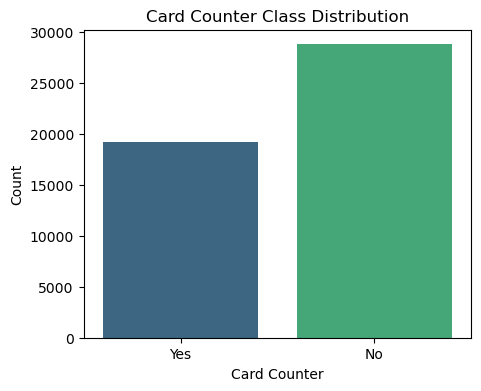

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the class distribution for Card_Counter
plt.figure(figsize=(5, 4))
sns.countplot(
    data=data, 
    x="Card_Counter", 
    hue="Card_Counter", 
    palette="viridis", 
    legend=False           # Removing duplicate legend
)
plt.title("Card Counter Class Distribution")
plt.xlabel("Card Counter")
plt.ylabel("Count")
plt.show()

### 2.4 True Count and Bet Size Distribution by `Card_Counter`
- These plots help us see how `True_Count` and Bet Size differ between counters and non-counters, which can indicate predictive power for the model.

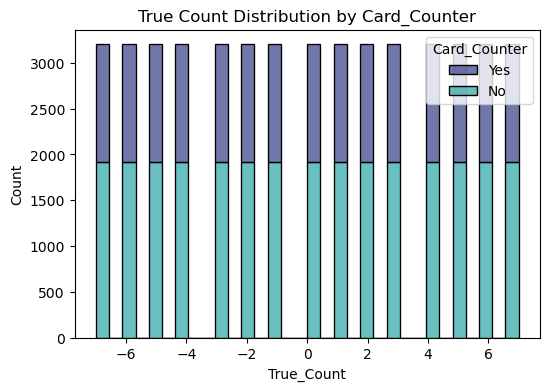

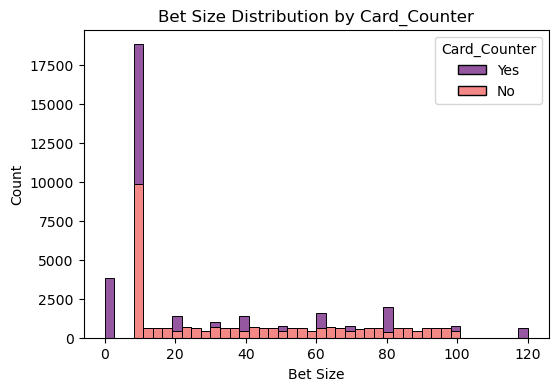

In [8]:
# Distribution of True_Count, split by Card_Counter class
plt.figure(figsize=(6, 4))
sns.histplot(data=data, x="True_Count", hue="Card_Counter", multiple="stack", palette="mako")
plt.title("True Count Distribution by Card_Counter")
plt.show()

# Distribution of Bet Size, split by Card_Counter class
plt.figure(figsize=(6, 4))
sns.histplot(data=data, x="Bet Size", hue="Card_Counter", multiple="stack", palette="magma")
plt.title("Bet Size Distribution by Card_Counter")
plt.show()

### 2.5 Correlation Heatmap
- This heatmap helps us identify which numeric features are strongly correlated and may be important for predicting card counters.

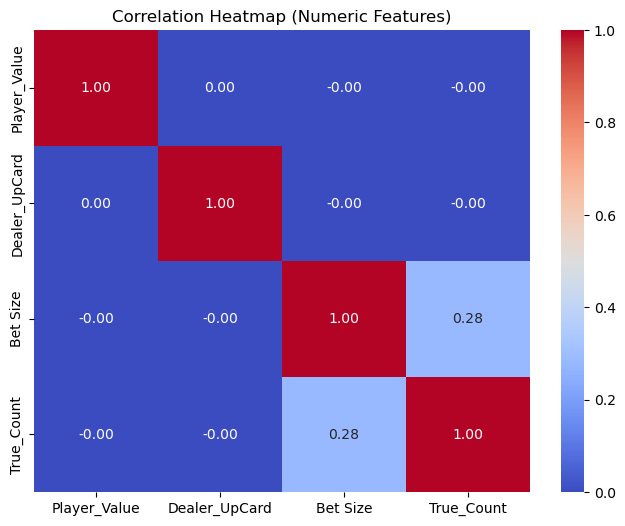

In [9]:
# Selecting numeric columns for correlation analysis
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Plotting a correlation heatmap to see relationships between numeric features
plt.figure(figsize=(8, 6))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

## 3. Data Preprocessing
### 3.1 Transforming Categorical -> Numeric
- This step transforms all categorical columns into numeric form so the models can handle them, while keeping a copy of the original data intact.

In [10]:
from sklearn.preprocessing import LabelEncoder

# Copying original data to avoid accidental changes
df_proc = data.copy()

# Encoding target variable: "Yes" -> 1, "No" -> 0
target_le = LabelEncoder()
df_proc["Card_Counter"] = target_le.fit_transform(df_proc["Card_Counter"])
# Check mapping with target_le.classes_ if needed

# Encoding binary categorical features
binary_cols = ["Soft", "Pair"]
for col in binary_cols:
    df_proc[col] = LabelEncoder().fit_transform(df_proc[col])

# Encoding multi-class categorical feature: Action
df_proc["Action"] = LabelEncoder().fit_transform(df_proc["Action"])

# Previewing to confirm that encoding worked
print("\nEncoded columns preview:")
display(df_proc.head())


Encoded columns preview:


,Player_Value,Dealer_UpCard,Soft,Pair,Bet Size,Action,True_Count,Card_Counter
0,4.0,2.0,0,1,10.0,1,0.0,1
1,4.0,3.0,0,1,10.0,1,0.0,1
2,4.0,4.0,0,1,10.0,1,0.0,1
3,4.0,5.0,0,1,10.0,1,0.0,1
4,4.0,6.0,0,1,10.0,1,0.0,1


### 3.2 Scaling Features
- Scaling numerical features ensures that models like Logistic Regression and SVM treat all inputs equally and improves convergence.

In [11]:
from sklearn.preprocessing import StandardScaler

# Selecting numeric columns to scale
numeric_cols = ["Player_Value", "Dealer_UpCard", "Bet Size", "True_Count"]

# Standardizing features to have mean=0 and std=1
scaler = StandardScaler()
df_proc[numeric_cols] = scaler.fit_transform(df_proc[numeric_cols])

# Previewing scaled numeric features
print("\nScaled numeric features preview:")
display(df_proc[numeric_cols].head())


Scaled numeric features preview:


,Player_Value,Dealer_UpCard,Bet Size,True_Count
0,-1.991524,-1.566699,-0.76562,0.0
1,-1.991524,-1.218544,-0.76562,0.0
2,-1.991524,-0.870388,-0.76562,0.0
3,-1.991524,-0.522233,-0.76562,0.0
4,-1.991524,-0.174078,-0.76562,0.0


## 4. Test and Train Split
- We are splitting the dataset into training and test sets while preserving the ratio of card counters to non-counters, ensuring the model learns and is evaluated fairly.

In [12]:
from sklearn.model_selection import train_test_split

# Separating features (X) and target (y)
X = df_proc.drop("Card_Counter", axis=1)
y = df_proc["Card_Counter"]

# Splitting the data into training and test sets (80/20)
# Stratifying to keep the same class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Checking sizes and class distribution
print(f"Training set: {X_train.shape[0]} rows")
print(f"Test set: {X_test.shape[0]} rows")
print("Target distribution in train set:")
print(y_train.value_counts(normalize=True))

Training set: 38400 rows
Test set: 9600 rows
Target distribution in train set:
Card_Counter
0    0.6
1    0.4
Name: proportion, dtype: float64


## 5. Model Training
### 5.1 Logistic Regression
- We’re tuning Logistic Regression to maximize the F1 score, which balances precision and recall for detecting card counters.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid for Logistic Regression
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],        # regularization strength
    "penalty": ["l2"],               # standard L2 regularization
    "solver": ["lbfgs"],             # efficient solver for medium datasets
    "max_iter": [500]                # increase iterations to ensure convergence
}

# Initialize Logistic Regression
lr = LogisticRegression()

# Grid search with 5-fold cross-validation, optimizing F1 score
grid_lr = GridSearchCV(
    lr, param_grid_lr,
    cv=5, scoring="f1", n_jobs=-1
)

# Fit the model on training data
grid_lr.fit(X_train, y_train)

# Display best hyperparameters and corresponding F1 score
print("Best parameters:", grid_lr.best_params_)
print("Best CV F1 score:", grid_lr.best_score_)


Best parameters: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1 score: 0.3872090898937987


### 5.2 Logistic Regression Performance 
- We evaluate the model’s performance on unseen data to see how well it can detect card counters and avoid false positives.

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicting the target on the test set
y_pred_lr = grid_lr.predict(X_test)

# Detailed evaluation metrics: precision, recall, F1-score
print("--- Logistic Regression: Test Set Evaluation ---")
print(classification_report(y_test, y_pred_lr, target_names=["Non-Counter", "Counter"]))

# Confusion matrix to see correct vs. incorrect predictions
cm = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:")
print(cm)

--- Logistic Regression: Test Set Evaluation ---
              precision    recall  f1-score   support

 Non-Counter       0.64      0.82      0.72      5760
     Counter       0.54      0.31      0.40      3840

    accuracy                           0.62      9600
   macro avg       0.59      0.57      0.56      9600
weighted avg       0.60      0.62      0.59      9600

Confusion Matrix:
[[4742 1018]
 [2638 1202]]


### 5.3 Support Vector Machine (SVM)
- We are tuning a Support Vector Machine (SVM) with class balancing to better detect rare card counters, leveraging multiple CPU cores for faster grid search.

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Defining hyperparameter grid for SVM
param_grid_svm = {
    "C": [0.1, 1, 10],      # regularization strength
    "kernel": ["linear"],    # linear kernel for faster computation
}

# Initializing SVM with class weights to handle imbalance
svm = SVC(class_weight='balanced')

# Grid search with 5-fold CV, optimizing F1 score, using all CPU cores
grid_svm = GridSearchCV(
    svm,
    param_grid_svm,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

# Fitting the model
grid_svm.fit(X_train, y_train)

# Output best hyperparameters and CV score
print("Best parameters:", grid_svm.best_params_)
print("Best CV F1 score:", grid_svm.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...............................C=0.1, kernel=linear; total time=  18.9s
[CV] END ................................C=10, kernel=linear; total time=  34.8s
[CV] END ...............................C=0.1, kernel=linear; total time=  18.6s
[CV] END ................................C=10, kernel=linear; total time=  35.7s
[CV] END ...............................C=0.1, kernel=linear; total time=  20.1s
[CV] END ................................C=10, kernel=linear; total time=  34.4s
[CV] END ...............................C=0.1, kernel=linear; total time=  18.9s
[CV] END ................................C=10, kernel=linear; total time=  35.7s
[CV] END ...............................C=0.1, kernel=linear; total time=  19.3s
[CV] END ................................C=10, kernel=linear; total time=  35.6s
Best parameters: {'C': 1, 'kernel': 'linear'}
Best CV F1 score: 0.5921818433130535


### 5.4 SVM Performance
- We are assessing the SVM’s ability to correctly identify card counters and non-counters on unseen data, checking for both false positives and false negatives.

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict the target on the test set
y_pred_svm = grid_svm.predict(X_test)

# Evaluation metrics: precision, recall, F1-score
print("--- SVM: Test Set Evaluation ---")
print(classification_report(y_test, y_pred_svm, target_names=["Non-Counter", "Counter"]))

# Confusion matrix to visualize correct vs. incorrect predictions
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(cm_svm)

--- SVM: Test Set Evaluation ---
              precision    recall  f1-score   support

 Non-Counter       0.75      0.44      0.56      5760
     Counter       0.48      0.78      0.60      3840

    accuracy                           0.58      9600
   macro avg       0.62      0.61      0.58      9600
weighted avg       0.65      0.58      0.57      9600

Confusion Matrix:
[[2554 3206]
 [ 830 3010]]


### 5.5 Random Forest
- We are tuning a Random Forest to find the optimal tree structure and number of estimators for detecting card counters.

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for Random Forest
param_grid_rf = {
    "n_estimators": [100, 200],       # number of trees
    "max_depth": [None, 5, 10],       # tree depth
    "min_samples_split": [2, 5]       # minimum samples to split a node
}

# Initializing Random Forest
rf = RandomForestClassifier(random_state=42)

# Grid search with 5-fold CV optimizing F1 score
grid_rf = GridSearchCV(
    rf, param_grid_rf,
    cv=5, scoring="f1", n_jobs=-1
)

# Fitting the model
grid_rf.fit(X_train, y_train)

# Showing the best hyperparameters and CV F1 score
print("Best parameters:", grid_rf.best_params_)
print("Best CV F1 score:", grid_rf.best_score_)

Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1 score: 0.7522350358584925


### 5.6 Random Forest Performance
- We are evaluating Random Forest on the test set and examining which features most influence the model, helping interpret what drives card counter detection.

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicting on test set
y_pred_rf = grid_rf.predict(X_test)

# Evaluating performance
print("--- Random Forest: Test Set Evaluation ---")
print(classification_report(y_test, y_pred_rf, target_names=["Non-Counter", "Counter"]))

# Confusion matrix for visualizing correct vs incorrect predictions
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(cm_rf)

# Computing and displaying feature importances
importances = grid_rf.best_estimator_.feature_importances_
feat_names = X_train.columns
feat_importance_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:")
display(feat_importance_df)

--- Random Forest: Test Set Evaluation ---
              precision    recall  f1-score   support

 Non-Counter       0.85      0.81      0.83      5760
     Counter       0.73      0.79      0.76      3840

    accuracy                           0.80      9600
   macro avg       0.79      0.80      0.80      9600
weighted avg       0.81      0.80      0.80      9600

Confusion Matrix:
[[4663 1097]
 [ 802 3038]]

Feature Importance:


,Feature,Importance
4,Bet Size,0.530252
6,True_Count,0.171715
0,Player_Value,0.118101
1,Dealer_UpCard,0.077729
5,Action,0.067779
3,Pair,0.020510
2,Soft,0.013913


## 6. Model Comparison and Statistics
- This table summarizes how each model performs on unseen data, allowing us to quickly see which algorithm is best for detecting card counters.
### 6.1 Logistic Regression v/s SVM v/s Random Forest

In [19]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score

# Calculate the test F1 score and accuracy for each model
lr_test_f1 = f1_score(y_test, y_pred_lr)
lr_test_acc = accuracy_score(y_test, y_pred_lr)

svm_test_f1 = f1_score(y_test, y_pred_svm)
svm_test_acc = accuracy_score(y_test, y_pred_svm)

rf_test_f1 = f1_score(y_test, y_pred_rf)
rf_test_acc = accuracy_score(y_test, y_pred_rf)

# Compiling metrics into a comparison table
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Random Forest"],
    "Best CV F1": [grid_lr.best_score_, grid_svm.best_score_, grid_rf.best_score_],
    "Test F1": [lr_test_f1, svm_test_f1, rf_test_f1],
    "Test Accuracy": [lr_test_acc, svm_test_acc, rf_test_acc]
})

# Displaying the comparison
display(comparison)

,Model,Best CV F1,Test F1,Test Accuracy
0,Logistic Regression,0.387209,0.396700,0.619167
1,SVM,0.592182,0.598648,0.579583
2,Random Forest,0.752235,0.761881,0.802188


### 6.2 Feature Importance Visualization (Random Forest)
- This bar plot highlights which features most strongly influence the Random Forest model (We are considering Random Forest, since Random Forest had the highest Test Accuracy and the F1 score), helping interpret what factors drive card counter detection.

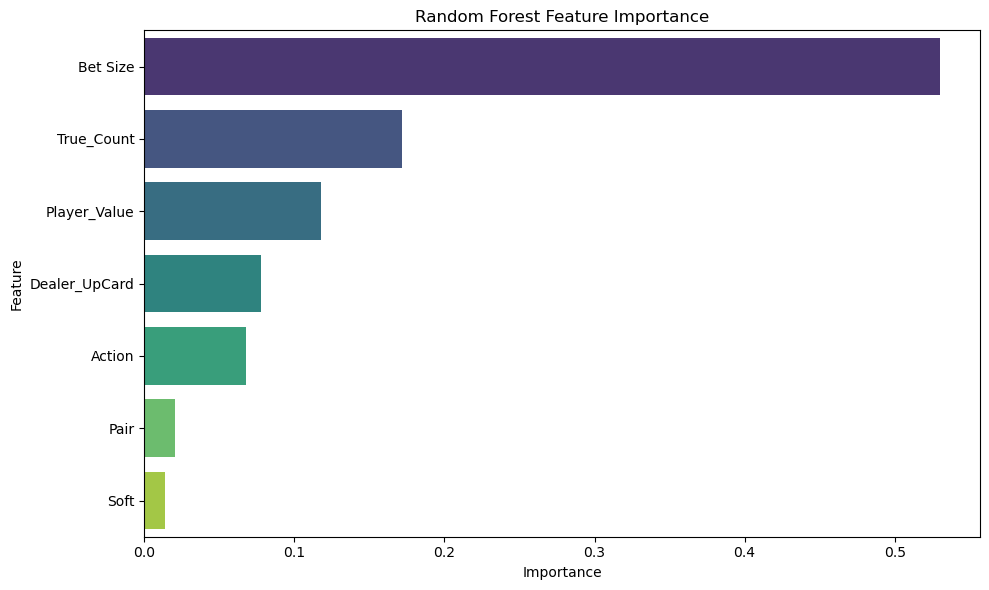

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing feature importances from Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=feat_importance_df,
    hue="Feature",
    palette="viridis",
    dodge=False,
    legend=False
)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### 6.3 Random Forest Confusion Matrix
- The heatmap helps us quickly see how many card counters and non-counters were correctly or incorrectly classified by the Random Forest model.

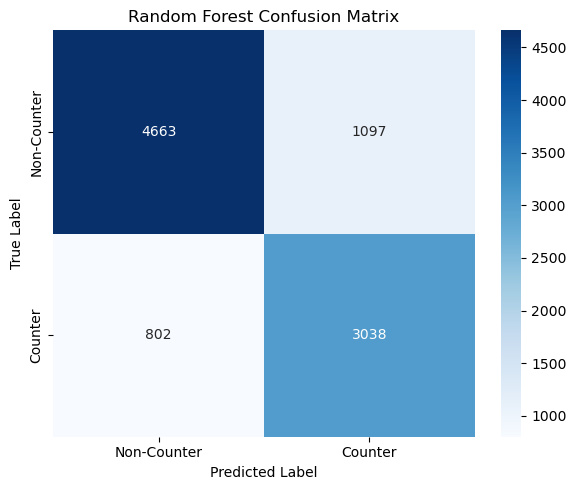

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the Random Forest confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_rf,                  # Confusion matrix from Random Forest predictions
    annot=True, fmt="d", 
    cmap="Blues",
    xticklabels=["Non-Counter", "Counter"],
    yticklabels=["Non-Counter", "Counter"]
)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### 6.4 Model Comparison Visualisation
- This visualization compares each model’s Test F1 and Accuracy side by side, making it easy to identify which model performs best for detecting card counters.

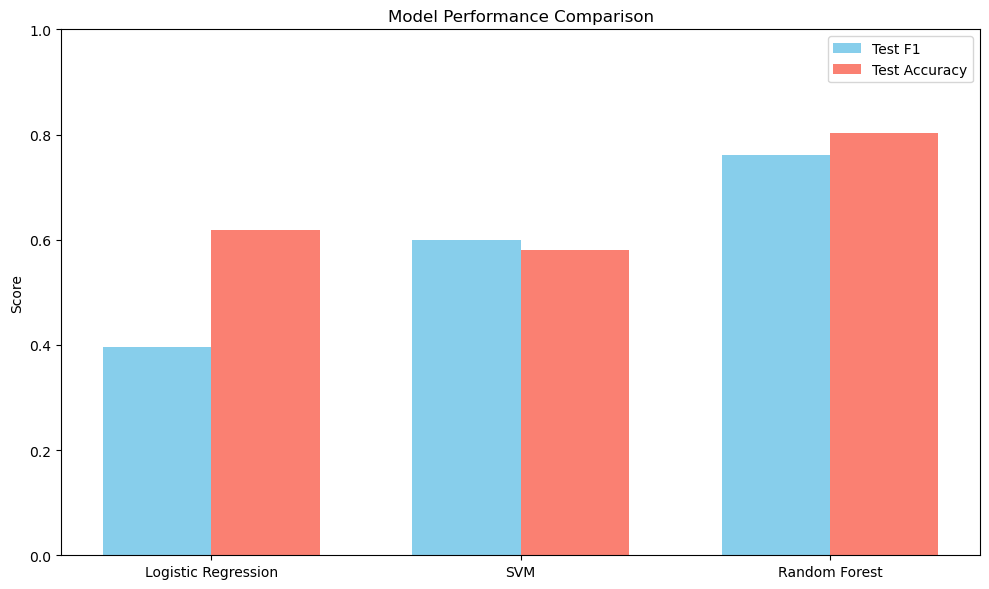

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(comparison))

# Plotting Test F1 scores
plt.bar(index, comparison["Test F1"], bar_width, label="Test F1", color="skyblue")

# Plotting Test Accuracy scores (shifted)
plt.bar([i + bar_width for i in index], comparison["Test Accuracy"], bar_width, label="Test Accuracy", color="salmon")

# Setting X-axis labels to model names
plt.xticks([i + bar_width / 2 for i in index], comparison["Model"])
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

## 7 Discussion & Conclusion
#### 1. Can card counters be detected?
- Our models indicate that it **is possible to detect card counters**, though detection is not perfect.  
- **Random Forest** achieved the best performance:  
  - **Test F1:** 0.76  
  - **Test Accuracy:** 0.80  
- Logistic Regression and SVM performed reasonably well but struggled to capture non-linear interactions between features.

#### 2. Most predictive features
- **Bet Size** is the strongest predictor — card counters adjust bets according to the true count.  
- **True Count** also contributes significantly, aligning with the theoretical basis of card counting.  
- Other features (Player Value, Dealer Upcard, Action, Pair, Soft) provide smaller but meaningful contributions.

#### 3. Limitations
- Dataset is **simulated**, not real casino data, which may **bias model performance**.  
- Models could **overfit** to patterns present in the simulated data but not in real-world scenarios.  
- Class imbalance (more Non-Counters than Counters) could affect metrics — mitigated by `class_weight='balanced'` for SVM.

#### 4. Key takeaway
- Card counting behaviors can be **detected algorithmically** using betting patterns and hand values.  
- Random Forest is the most reliable model in this dataset, showing that **ensemble methods capture non-linear interactions** better than linear models.
